In [1]:
import os
import getpass

from datasets import load_dataset
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


## Create Chunked Dataset

In [2]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
VALIDATION_SPLIT_PERCENTAGE = 4

In [4]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Total rows: 2115696


In [5]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)


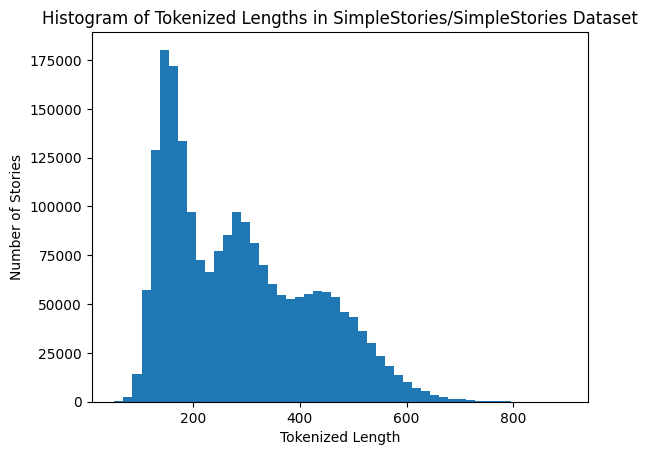

In [6]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [7]:
CHUNK_LENGTH = 64

train_dataset, test_dataset = tokenized_dataset.train_test_split(
    test_size=VALIDATION_SPLIT_PERCENTAGE / 100,
    seed=42,
).values()

def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_test = chunk_dataset_with_map(test_dataset, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2031068 [00:00<?, ? examples/s]

Map:   0%|          | 0/84628 [00:00<?, ? examples/s]

In [8]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_test = len(chunked_dataset_test)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_test}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_test)/total_tokens_original * 100}% of the original tokens (train)")

Total available tokens = 608.617592M tokens
Total tokens in chunked dataset (train) = 520.93344M tokens
Total tokens in chunked dataset (test) = 21.734464M tokens
We are left with 89.16401877519178% of the original tokens (train)


In [9]:
# split_dataset = chunked_dataset.train_test_split(test_size=VALIDATION_SPLIT_PERCENTAGE/100)
# print(f"Train set size: {len(split_dataset['train'])} samples")
# print(f"Validation set size: {len(split_dataset['test'])} samples")
import datasets
split_dataset = datasets.DatasetDict({
    'train': chunked_dataset_train,
    'test': chunked_dataset_test
})
split_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)

# chunked_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)


Uploading the dataset shards:   0%|          | 0/17 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-64/commit/2654756ac133a85cad38dad864d30e257dc5fcfc', commit_message='Upload dataset', commit_description='', oid='2654756ac133a85cad38dad864d30e257dc5fcfc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-64', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/SimpleStories-SimpleStories-chunked-64'), pr_revision=None, pr_num=None)

## Dataset Exploration

In [ ]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [10]:
tokenizer.get_vocab()

{'gripped': 3351,
 'keep': 882,
 '##ide': 220,
 'warri': 3404,
 '##lls': 3480,
 'snowflakes': 3058,
 'lush': 3951,
 'face': 829,
 '##its': 3954,
 'exc': 398,
 'flo': 907,
 'wish': 845,
 'wrapped': 2296,
 'send': 2736,
 'planets': 2589,
 'war': 435,
 '##ilies': 3053,
 'treat': 2531,
 'rough': 3527,
 'writ': 2546,
 'burden': 3668,
 '##ugg': 1120,
 'branches': 1916,
 'snowball': 2847,
 'have': 589,
 '##eless': 3645,
 'cand': 1351,
 '##tle': 456,
 'climb': 824,
 '##uly': 2003,
 'shaking': 2332,
 'vic': 2575,
 'jean': 745,
 'happening': 2586,
 'warning': 2812,
 'working': 1823,
 'civ': 3128,
 'not': 191,
 'who': 427,
 'p': 47,
 'faces': 1507,
 'cle': 1642,
 'wr': 615,
 'simple': 2075,
 'loudly': 2241,
 'job': 2876,
 'wisely': 3113,
 'longing': 2561,
 'statue': 3312,
 'just': 300,
 'being': 905,
 'wat': 487,
 'empty': 1297,
 '##iny': 873,
 '##her': 148,
 'puddle': 3981,
 'hesit': 1752,
 'rec': 1512,
 'leader': 1384,
 'early': 3455,
 '##ms': 1413,
 'blooms': 3587,
 '##ieved': 4093,
 'surface'

In [11]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined